In [27]:
from scipy.linalg import sqrtm
import cvxpy as cp
from sympy.utilities.lambdify import lambdify
import sympy as sp
import numpy as np
from scipy.linalg import solve_discrete_are as dare 
from scipy.signal import cont2discrete
import time
from matplotlib.pyplot import *


Coupled masses dynamical system:

$$
\begin{cases}
m_1\ddot{y}_1 + k(y_1 - y_2) = F \\ 
m_2\ddot{y}_2 + k(y_2 - y_1) = 0
\end{cases}
$$

In [28]:
# system parameters
m_1 = 1
m_2 = 3
K = 100

param = m_1, m_2, K
u_d = 2

x_d = np.array([0.7,0.5,0,0])
Q = 10*np.diag([1,100,1,1])

R = np.array([0.1])
C = np.array([[1, 0, 0 ,0]])
D = np.array([[0, 0]])
t0 = 0
T = 5
freq = 50
N = int(freq*T)
dt = 1/freq
t = np.array(range(N+1))*dt

In [29]:
A = np.array([[0,0,1,0],
             [0,0,0,1],
             [-K/m_1, K/m_1, 0, 0],
             [K/m_2, -K/m_2, 0, 0]])

B = np.array([[0],
             [0],
             [1/m_1],
             [0]])

In [30]:
A_d, B_d, C_d, D_d, _ = cont2discrete((A,B,C,D), dt)

def dlqr(A, B, Q, R):
    '''Discrete time LTI LQR'''
    # Solve the DARE
    P = dare(A, B, Q, R)
    # Compute the LQR gain
    R_inv = np.linalg.inv(R + B.T @ P @ B )
    K = R_inv @ (B.T @ P @ A)
    return K, P

K_LQR, P = dlqr(A_d, B_d, Q, R)

In [31]:
# define dimensions
H, n, m = 20, 4, 1

# define variables
U = cp.Variable((m, H), name='U')
X = cp.Variable((n, H+1), name='X')

# define parameters
Psqrt = sqrtm(P)
Qsqrt = sqrtm(Q)
Rsqrt = sqrtm([R])
U_max = cp.Parameter(m, name='U_max')
U_min = cp.Parameter(m, name='U_min')
X_max = cp.Parameter((n,1), name='X_max')
X_min = cp.Parameter((n,1), name='X_min')

A = cp.Parameter((n, n), name='A')
B = cp.Parameter((n, m), name='B')
x_init = cp.Parameter(n, name='x_init')

# define objective
objective = cp.Minimize(cp.sum_squares(Psqrt@X[:,H]) + cp.sum_squares(Qsqrt@X[:,:H])  
                        + cp.sum_squares(Rsqrt@U))

# define constraints
constraints = [X[:,1:] == A@X[:,:H]+B@U,
               U <= U_max,
               U >= U_min,
               X <= X_max,
               X >= X_min,
               X[:,0] == x_init]

# define problem
problem = cp.Problem(objective, constraints)

In [32]:
x0 = np.array([0.2, 
      0.2, 
      0, 
      0])
print(x0.shape)

problem.param_dict['A'].value = A_d
problem.param_dict['B'].value = B_d
problem.param_dict['U_max'].value = [5]
problem.param_dict['U_min'].value = [-5]
problem.param_dict['X_max'].value = 1000*np.ones((4,1))
problem.param_dict['X_min'].value = -1000*np.ones((4,1))
problem.param_dict['x_init'].value = x0

(4,)


t0 = time.time()
val = problem.solve()
t1 = time.time()
print('\nCVXPY\nSolve time: %.3f ms' % (1000 * (t1 - t0)))
print('Objective function value: %.6f\n' % val)

X_opt = problem.var_dict['X'].value
U_opt = problem.var_dict['U'].value

In [33]:
t0 = time.time()
val = problem.solve()
t1 = time.time()
print('\nCVXPY\nSolve time: %.3f ms' % (1000 * (t1 - t0)))
print('Objective function value: %.6f\n' % val)
t0 = time.time()
val = problem.solve()
t1 = time.time()
print('\nCVXPY\nSolve time: %.3f ms' % (1000 * (t1 - t0)))
print('Objective function value: %.6f\n' % val)

X_opt = problem.var_dict['X'].value
U_opt = problem.var_dict['U'].value


CVXPY
Solve time: 32.471 ms
Objective function value: 859.571731


CVXPY
Solve time: 10.450 ms
Objective function value: 859.573704



(4, 21)
(1, 20)


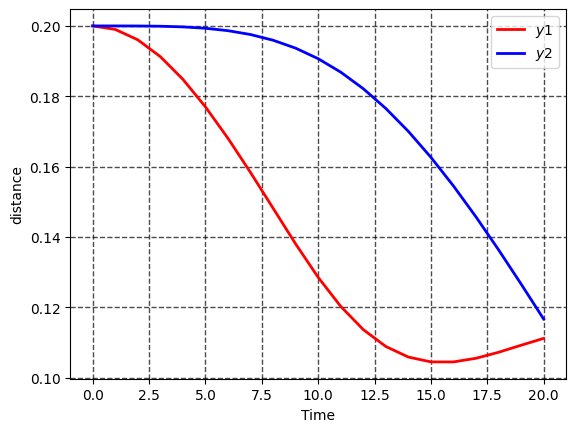

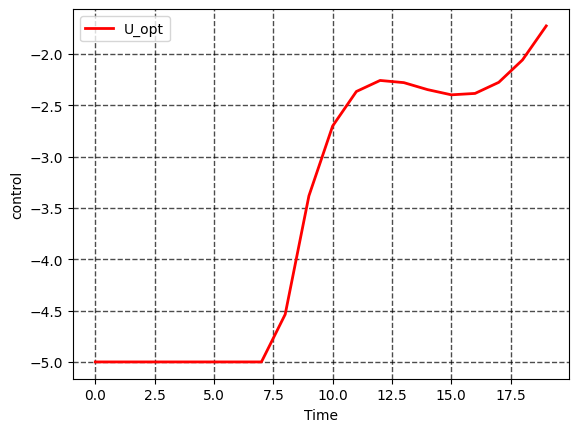

In [34]:
print(X_opt.shape)
print(U_opt.shape)
y1, y2,dy1, dy2 = X_opt

plot(y1, 'r', linewidth=2.0, label = r'$y1$')
plot(y2, 'b', linewidth=2.0, label = r'$y2$')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
legend()
ylabel('distance')
xlabel('Time')
show()

plot(U_opt[0,:], 'r', linewidth=2.0, label = "U_opt")
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
legend()
ylabel('control')
xlabel('Time')
show()

### Simulation

In [35]:
# X = x0

u_max = 10
solve_time = []
time_stat = []
U = 0

problem.param_dict['X_max'].value = np.array([[10000], [10000], [10000], [10000]])
problem.param_dict['X_min'].value = np.array([[-10000], [-10000], [-10000], [-10000]])
problem.param_dict['U_max'].value = [u_max]
problem.param_dict['U_min'].value = [-u_max]

X_runge = np.zeros((4, len(t)))
X_runge[:, 0] = x0

def f(x, u, parameters):
    m1, m2, k = parameters
    y1, y2, dy1, dy2 = x

    ddy1 = 1/m1 *(u - k*(y1 - y2))
    ddy2 = 1/m2 *(-k*(y2 - y1))

    return np.array([dy1, dy2, ddy1, ddy2])

for k in range(N):
  # MPC CONTROL
  problem.param_dict['x_init'].value = x0

  t1 = time.perf_counter()
  val = problem.solve()
  t2 = time.perf_counter()
  time_stat.append(t2 - t1)

  U_opt = problem.var_dict['U'].value
  u = U_opt[0][0]

  k1 = f(X_runge[:, k], u, param)
  k2 = f(X_runge[:, k] + ((dt/2)*k1), u, param)
  k3 = f(X_runge[:, k] + ((dt/2)*k2), u, param)
  k4 = f(X_runge[:, k] + (dt*k3), u,  param)
  
  X_runge[:, k+1] = X_runge[:, k] + (dt/6)*(k1 + 2*k2 + 2*k3 + k4) 

  x0 = X_runge[:, k+1]
  U = np.vstack((U, u))


y1, y2, dy1, dy2 = X_runge
t = np.array(range(N+1))*dt

  # x0 = A_d@x0 + B_d@[u]
  # X = np.vstack((X, x0))

In [36]:
np.mean(time_stat)

0.0050655216003069655

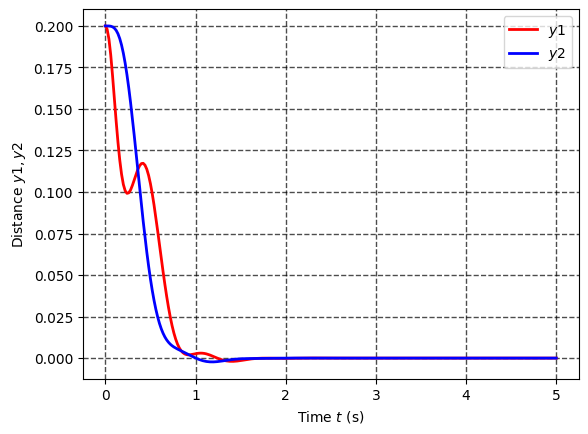

In [37]:
plot(t, y1, 'r', linewidth=2.0, label = r'$y1$')
plot(t, y2, 'b', linewidth=2.0, label = r'$y2$')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
legend()
ylabel(r'Distance $y1, y2$')
xlabel(r'Time $t$ (s)')
show()

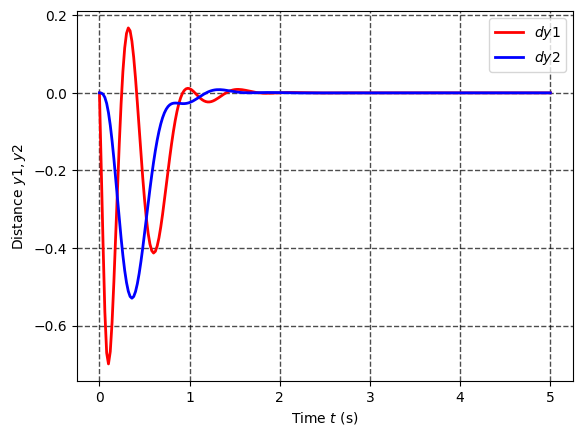

In [38]:
plot(t, dy1, 'r', linewidth=2.0, label = r'$dy1$')
plot(t, dy2, 'b', linewidth=2.0, label = r'$dy2$')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
legend()
ylabel(r'Distance $y1, y2$')
xlabel(r'Time $t$ (s)')
show()

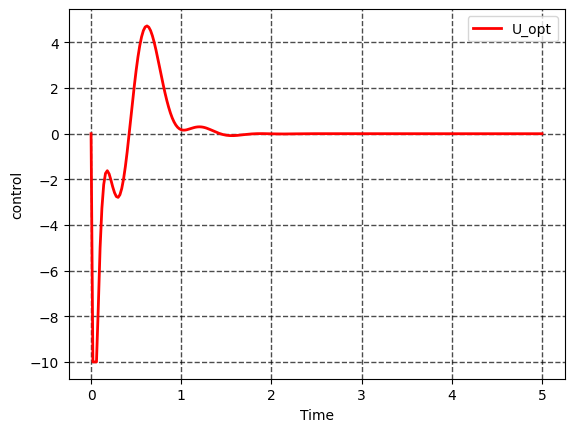

In [39]:
plot(t, U, 'r', linewidth=2.0, label = "U_opt")
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
legend()
ylabel('control')
xlabel('Time')
show()